# fly_data object : defined in working_functions.py

Things to implement in it :
    -more metadata ?

method the object should have :
    -output the object seen by the fly at a given time based on all the other fly object in the "session" (or just given a number of fly objects)

In [1]:
    ### Necessary modules

#for plots
import matplotlib.pyplot as plt
import operator


# trajectorytools needs to be installed. To installed follow the instructions 
# at http://www.github.com/fjhheras/trajectorytools
from trajectorytools.constants import dir_of_data
import trajectorytools as tt
import trajectorytools.plot as ttplot
import trajectorytools.socialcontext as ttsocial
import copy
from scipy import stats
import numpy as np
import cv2
import skvideo.io
import imutils
import numpy.ma as ma
import scipy.signal as sgl


from matplotlib.axes import Axes as ax

#My functions
import working_functions as flyD
#import graphing_data #Not useful at the moment

#For importing files and timing cells.
import time
import matplotlib.mlab as mlab

Analysis function based on numerous fly_data objects from a single video :

    -position_summary: summarizes where we can find other flies relatively to our focus fly

    -A focus fly should be defined
    -Relative_fly object should be calculates based on the focus fly
    -What to calculate of this ?
    -Correlation between "turning" of the fly (derivation of orientation) and position of other flies ("global" position and specific position of every fly)

Landscape function ?:
    -Given a focus fly and a set of object, single-object projection of everything the fly sees ? 

Cell below doesn't need to be executed, is just here to write down data so it's possible to pick it up quickly afterward (get_ori takes ~6min to run)

In [2]:
# flyD.save_ori_pickle("fly2")
# flyD.save_ori_pickle("3flies")
flyD.save_ori_pickle("6flies_1")
# flyD.save_ori_pickle("6flies_2")

/home/maubry/python/idtrackerai/working_functions.py:396: RuntimeWarning: invalid value encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))
/home/maubry/python/idtrackerai/working_functions.py:396: RuntimeWarning: divide by zero encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))
/home/maubry/python/idtrackerai/working_functions.py:123: RuntimeWarning: invalid value encountered in greater
  crop_dir[dir_var>30] = np.nan


time elapsed : 7.0min and 10sec


/home/maubry/python/idtrackerai/working_functions.py:101: RuntimeWarning: invalid value encountered in less
  
/home/maubry/python/idtrackerai/working_functions.py:104: RuntimeWarning: invalid value encountered in less
  self.ori_rel = ori_rel


[101.59165125 302.18469172 312.87777523 ... 312.96376369 311.51217858
 311.82943639]


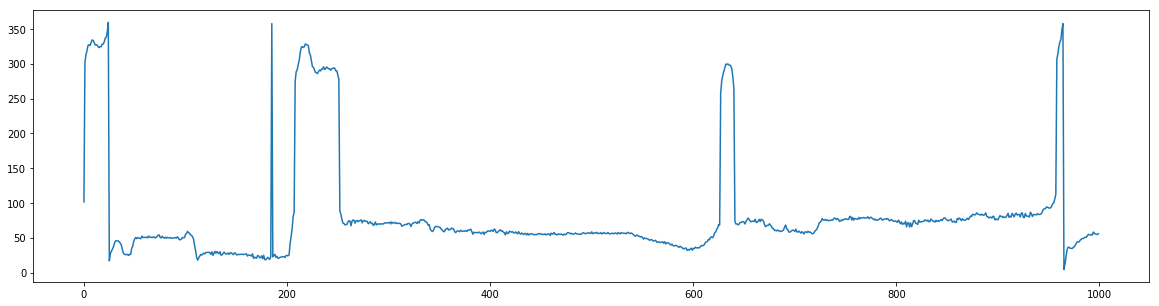

In [6]:
flystack = flyD.get_ori_pickle('6flies_1')

fly = flystack[1]
fly_correc = copy.deepcopy(fly)
#fly_correc.ori_correc(overwrite=True) #Now not necessary, as it is done by default.

fly2 = flystack[2]
fly2_correc = copy.deepcopy(fly2)
#fly2_correc.ori_correc(overwrite=True)
# #Get first fly and correct its orientations (correction now done by default)

rel = flyD.relative_fly(fly_correc, fly2_correc)
showrange = range(10000)

plt.figure(figsize=(20,5))
#plt.plot(fly_correc.orientations)
plt.plot(rel.angle[:1000])
print(rel.angle)

/home/maubry/python/idtrackerai/working_functions.py:114: RuntimeWarning: invalid value encountered in less
  angle[angle < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:117: RuntimeWarning: invalid value encountered in less
  ori_rel[ori_rel < 0] += 360


Video file saved as 6flies_2_ori.avi.


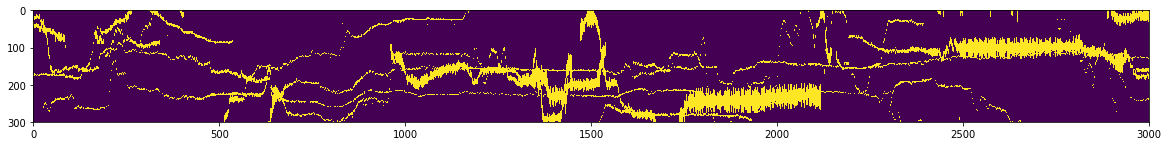

<Figure size 1440x360 with 0 Axes>

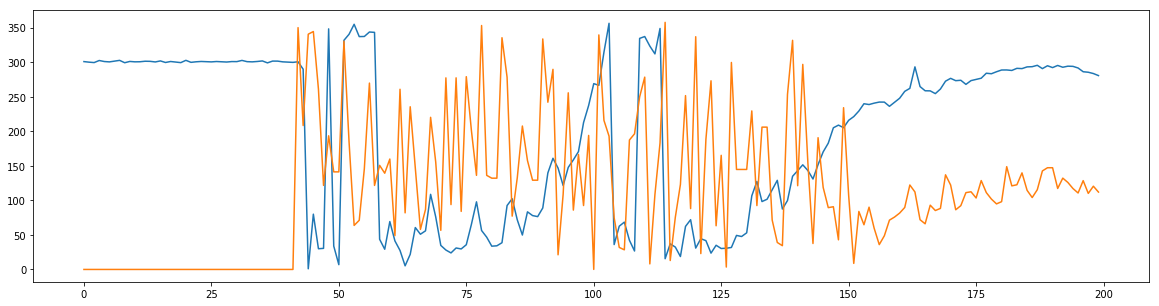

In [52]:
#Defining landscape function.
#For a specific fly, should output what the fly sees as stimilus for every frames.

    #Convert everything into a simple matrix of occupied pixels
    
stack = flyD.get_ori_pickle('6flies_1')

identity = 5
hue = flyD.landscape(stack, identity)

#fig, ax_meanposmap = plt.subplots(figsize=(200,20))
#ax_meanposmap.imshow(X=hue[:1000,])

time_range = range(3000)

hue_trans = np.transpose(hue)
fig, ax_meanposmap = plt.subplots(figsize=(20,200))
ax_meanposmap.imshow(X=hue_trans[...,time_range])
plt.figure(figsize=(20,5))

plt.figure(figsize=(20,5))
#plt.plot(fly_correc.orientations)
plt.plot(stack[identity].orientations[:200])
plt.plot(stack[identity].directions[:200])
flystack = copy.deepcopy(stack)

for fly in flystack:
    fly.orientations = fly.old_ori

#flyD.draw_ori("raw/6flies_1.avi", flystack,output_name=session+"_ori.avi", corrected = True)

#flyD.flyvision("huehue.avi", hue, 0, 500)


## Correlation between landscape and behaviour 

We want to find correlations between behaviour at time T (e.g. turning left) to previous landscape (e.g. last 30 frames).
How to avoid correlation betwee past behaviour and current behaviour ? 
    -Need moment when behaviour *begins* to avoid inertia effect.

In [ ]:
# flyD.save_ori_pickle("fly2")
sessions = ('fly2','3flies','6flies_1','6flies_2')

# for session in sessions:
#     flystack = flyD.get_ori_pickle(session)

#     flyD.draw_ori("raw/"+session+".avi", flystack,output_name=session+"_ori.avi", corrected = True)
    

flystack = flyD.get_ori_pickle("6flies_1")
for fly in flystack:
    fly.ori_correc()

lines = flyD.landscape(flystack, 1)

print(lines[210:390,...])

fig, ax_meanposmap = plt.subplots()
ax_meanposmap.imshow(X=lines[500:600,...])

relfly = flyD.relative_fly(flystack[1],flystack[3])
print(relfly.ori_rel)
print(relfly.dist[510:560])
#flyD.flyvision("flyvision_new.avi", lines, 210, 390)



/home/maubry/python/idtrackerai/working_functions.py:124: RuntimeWarning: invalid value encountered in greater
  crop_dir[dir_var>30] = np.nan


In [31]:
#Calculate moving average and variance for every point :

def rolling_stats_ori(fly, window_size):
    
    mean = np.zeros(shape=(len(fly.orientations)))
    var = np.zeros(shape=(len(fly.orientations)))
    dir_mean = np.zeros(shape=(len(fly.orientations)))
    dir_var = np.zeros(shape=(len(fly.orientations)))
    x =  window_size #half the size of the window    
    for i in range(len(fly.orientations)):
        ori_chunk = fly.orientations[int(i-x):int(i+x)]
        dir_chunk = fly.directions[int(i-x):int(i+x)]
        
        mean[i] = np.degrees(stats.circmean(np.radians(ori_chunk)))
        var[i] = np.degrees(stats.circvar(np.radians(ori_chunk)))
        dir_var[i] = np.degrees(stats.circvar(np.radians(dir_chunk)))
        dir_mean[i] = np.degrees(stats.circmean(np.radians(dir_chunk)))

    return dir_var, dir_mean

#Search for fly that begin turning



#Get the landscape of those fly just before they turned



flystack = flyD.get_ori_pickle('6flies_1')

focus = flystack[3]

var, mean = rolling_stats_ori(focus, 2)
var2, mean2 = rolling_stats_ori(focus, 5)
var = var
valid = np.zeros_like(var)
#valid[:] = np.nan
valid[var <= 10] = 1
valid[var <= 1] = 0


rolling_mean = np.zeros_like(valid)
x =  10 #half the size of the window

time_range = range(3000)
plt.figure(figsize=(20,5))
#plt.plot(fly_correc.orientations)
#plt.plot(focus.old_ori[8000:9000])
#plt.plot(focus.directions[time_range])
plt.plot(focus.orientations[time_range])
#plt.plot(focus.orientations[time_range])
plt.plot(focus.speeds[time_range])
plt.plot(var[time_range])

#print(var[time_range])
      
#print(focus.orientations[17300]-focus.old_ori[17300])

NameError: name 'rolling_stats_ori' is not defined

In [13]:
%%time

##Writes a video focusing on a single fly. Video currently set up to demonstrate how and under 
            #which conditions direction can be useful

path_to_vid = "raw/6flies_1.avi"

flystack = flyD.get_ori_pickle('6flies_1')
focus = flystack[2]

thresh=50

cap = cv2.VideoCapture(path_to_vid)
framerate=30
fps=str(framerate)
inputdict={'-r': fps}
outputdict={'-vcodec': 'libx264', '-pix_fmt': 'yuv420p', '-r': fps}
font = cv2.FONT_HERSHEY_SIMPLEX
output_name = "solofly3.avi"
writer = skvideo.io.FFmpegWriter(output_name, inputdict, outputdict)

p = 40
take_from = 2200
cap.set(1,take_from)
# for i in range(take_from):
#     ret, img = cap.read()
    
for i in range(120):
    center = focus.positions[int(i+take_from)]
    center = center.astype('int')

    angle = np.radians(focus.directions[int(i+take_from)])
    
    
    newx = center[0]+(np.cos(angle)*20) #Get distance forward in x
    newy = center[1]+(np.sin(angle)*20) #Get distance forward in y
            
    center_plus = (int(newx),int(newy)) #Second point of vector
            
    center = tuple(center) #Conversion to please cv2
    center_plus = tuple(center_plus)
    
    
    ret, img = cap.read()
    
    thresh = 50
    #ret, img = cv2.threshold(img,thresh,255,cv2.THRESH_BINARY) #Sets the video to binary according to thresh
    
    cv2.arrowedLine(img, center, center_plus, (255,0,0)) #Draw line

    
    crop_img = img[int(center[1]-p):int(center[1]+p), 
                   int(center[0]-p):int(center[0]+p)]
    
    writer.writeFrame(crop_img)
    
writer.close() 

CPU times: user 1.35 s, sys: 7.94 ms, total: 1.36 s
Wall time: 1.39 s


/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


-90.0


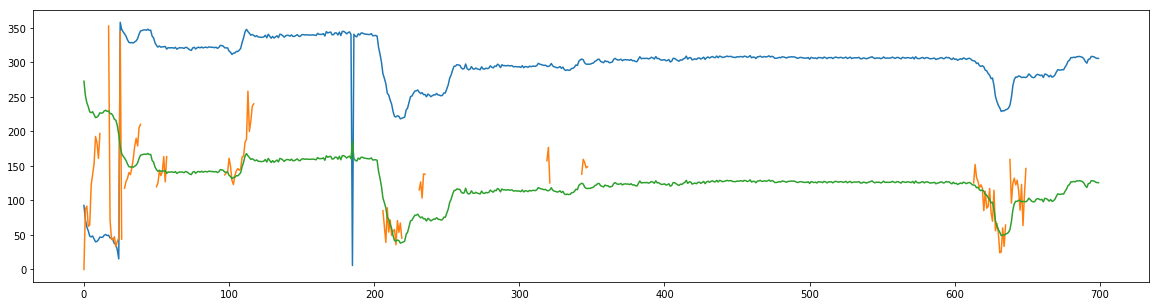

In [26]:
#Ori_correc should be modified to get chunked correlation,
    #because as of now correlation over the whole video is as good as random.

flystack = flyD.get_ori_pickle("6flies_1")
fly = flystack[1]

raws = flyD.flip(fly.old_ori, 90, ref=180)
correc = flyD.convertToTrigo(raws, reverse=False)
flipped = flyD.flip(correc)

crop_dir = copy.deepcopy(fly.directions)
dir_var = flyD.rolling_var_ori(crop_dir, 2)
crop_dir[dir_var>30] = np.nan


plt.figure(figsize=(20,5))
plt.plot(correc[:700])
plt.plot(crop_dir[:700])
plt.plot(fly.orientations[:700])

print(fly.old_ori[11500]-fly.orientations[11500])



#draw_ori("raw/6flies_1.avi", flystack,output_name="draw_ori_new.avi", corrected = True)

/home/maubry/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/maubry/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


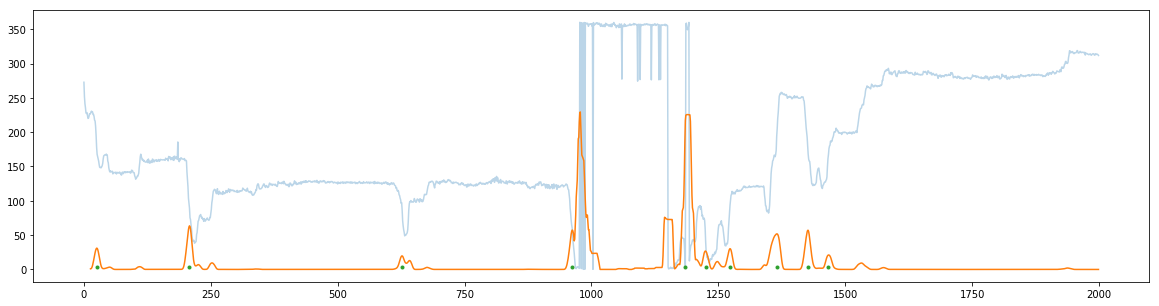

In [35]:
fly = flyD.get_ori_pickle("6flies_1")[1]
peaks = flyD.orientation_peaks(fly.orientations[:2000])
ys = np.zeros_like(peaks[0])
ys[:] = 4



plt.figure(figsize=(20,5))
plt.plot(fly.orientations[:2000], alpha=0.3)
plt.plot(flyD.rolling_stat(stats.circvar,10)(flyD.rolling_stat(np.mean, 3)(np.radians(fly.orientations[:2000])))*100)
plt.plot(peaks[0], ys, ".")

i=0
# for peak in peaks[0]:
#     width = peaks[1]['widths'][i]
#     solo_plot = range(peak-30,peak+30)
#     plt.figure(figsize=(10,5))
#     plt.ylim(0,np.pi*2)
#     plt.plot(mean[solo_plot], alpha=1)
#     plt.plot(ori_var(mean)[solo_plot]*5)
#     plt.plot(30-width/2,4, '.', markersize=10)
#     i+=1

#Taking 30 frames before te begining of each peak should be nice.
#Next step : embed peak finding in a function (how much leverage in variance etc ?) and find 
                #corresponding flyvision matrices.

/home/maubry/python/idtrackerai/working_functions.py:178: RuntimeWarning: invalid value encountered in less
  angle[angle < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:181: RuntimeWarning: invalid value encountered in less
  ori_rel[ori_rel < 0] += 360


(30, 300, 10)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02333333 0.09333333 0.1
 0.1        0.07666667 0.01       0.01666667 0.03       0.02333333
 0.02666667 0.03666667 0.02333333 0.03333333 0.04666667 0.03333333
 0.02333333 0.01666667 0.00666667 0.         0.         0.
 0.         0.         0.         0.         0.00333333 0.00333333
 0.00666667 0.03666667 0.04666667 0.03333333 0.03       0.01666667
 0.00333333 0.00333333 0.01333333 0.01       0.01666667 0.03666667
 0.02       0.00666667 0.00666667 0.         0.         0.
 0.         0.         0.00333333 0.00666667 0.00666667 0.00333333
 0.01       0.01       0.01       0.02333333 0.01333333 0.01333333
 0.02       0.01       0.00333333 0.02      

TypeError: Invalid dimensions for image data

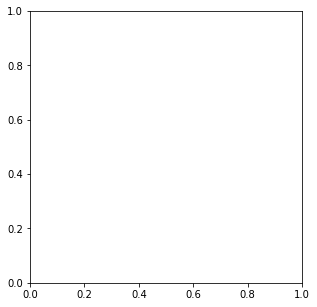

In [77]:
flystack = flyD.get_ori_pickle("6flies_1")
identity = 1
fly = flystack[identity]

peaks = flyD.orientation_peaks(fly.orientations[:2000])
vision = flyD.landscape(flystack, identity)
peak_beg = np.zeros_like(peaks[0])
peak_beg = peaks[0] - peaks[1]['widths']
n_peaks = len(peak_beg)
peaks
preturn_vision = np.zeros([30,300,n_peaks])
for i in range(n_peaks):
    beg = peak_beg[i]
    try:
        preturn_vision[:,:,i] = vision[int(beg-30):int(beg),]
    except:
        continue
        
print(preturn_vision.shape)
distrib = stats.describe(preturn_vision)[2]
distrib = np.transpose(distrib)
distrib = stats.describe(distrib)[2]
print(distrib)
plt.figure(figsize=(20,5))
plt.imshow(distrib, cmap='hot', interpolation='nearest')
plt.show()